In [1]:
import os
import sys
from collections import Counter
from multiprocessing import Pool
import glob

import pandas as pd
from PIL import Image
from tqdm import tqdm

sys.path.append('..')
from utils.config import width, height

In [2]:
data_dir_metadata = '../data/intermediary/google_search/'

In [3]:
painted_files = glob.glob(os.path.join(
    data_dir_metadata, 
    'iPhone-X/*/*/*/*/png/abstract_painting.png'
))
len(painted_files)

15264

In [4]:
# painted_files = painted_files[:30]

In [5]:
boarder = (0, 0, width, height)

In [6]:
def count_pixels(fn):
    """
    Opens a file from s3, counts the color of all pixels for the full page and the first glance
    """
    with Image.open(fn) as img:
        colors_full = Counter()
        colors_fg = Counter()

        colors_full.update(img.getdata())
        colors_fg.update(img.crop(boarder).getdata())
        
        width, height = img.size

        row = {
            'fn' : fn,
            'pixels_fullpage' : dict(colors_full),
            'pixels_firstglance' : dict(colors_fg),
            'height' : height,
            'width' :width
        }
        
        return row

In [7]:
n_processes = 12

data = []
with Pool(n_processes) as pool:
    for record in tqdm(pool.imap_unordered(count_pixels, 
                                           painted_files), 
                       total=len(painted_files)):
        data.append(record)

100%|██████████| 15264/15264 [09:17<00:00, 27.38it/s]


In [8]:
rgb2color = {
    (255, 255, 255) : 'white',
    (234, 67, 53) : 'ads',
    (178, 178, 178) : 'organic',
    (251, 188, 5) : 'links',
    (52, 168, 83) : 'answers',
    (108, 177, 238) : 'amp'  
}

In [9]:
data[1]['width']

375

In [10]:
records_full = []
records_fg = []
for record in tqdm(data):
    fg = {rgb2color.get(k, k) : v for k, v in record['pixels_firstglance'].items()}
    full = {rgb2color.get(k, k) : v for k, v in record['pixels_fullpage'].items()}

    row = {'fn' : record['fn']}
    records_fg.append({**row, **fg})
    records_full.append({**row, **full})

100%|██████████| 15264/15264 [00:00<00:00, 281092.27it/s]


In [11]:
fg = pd.DataFrame(records_fg)

In [12]:
full = pd.DataFrame(records_full)

In [13]:
full

,fn,white,ads,links,amp,organic,answers,"(0, 0, 0)","(33, 13, 2)","(193, 96, 11)",...,"(7, 0, 0)","(169, 64, 49)","(80, 253, 45)","(79, 29, 46)","(4, 136, 0)","(201, 65, 49)","(224, 64, 47)","(170, 64, 49)","(200, 44, 46)","(16, 45, 46)"
0,../data/intermediary/google_search/iPhone-X/20...,532902,123879.0,180250.0,284098.0,688383.0,186238.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,../data/intermediary/google_search/iPhone-X/20...,362214,NaN,214441.0,33659.0,705798.0,95013.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,../data/intermediary/google_search/iPhone-X/20...,480377,93675.0,156791.0,NaN,702156.0,617876.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,../data/intermediary/google_search/iPhone-X/20...,325053,NaN,202057.0,NaN,740151.0,125864.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,../data/intermediary/google_search/iPhone-X/20...,374547,85362.0,241263.0,108958.0,637786.0,158584.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15259,../data/intermediary/google_search/iPhone-X/20...,637818,45804.0,407537.0,330169.0,485328.0,230469.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15260,../data/intermediary/google_search/iPhone-X/20...,500306,NaN,211784.0,NaN,807529.0,310381.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15261,../data/intermediary/google_search/iPhone-X/20...,531830,NaN,382588.0,362268.0,453563.0,171001.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15262,../data/intermediary/google_search/iPhone-X/20...,415310,NaN,332261.0,260250.0,465030.0,154649.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
label2publabel = {
    'link' : 'Google Product',
    'answer' : 'Google Answer',
    'organic' : 'Organic',
    'amp' : 'AMP',
    'ads' : 'Ads',
    'white' : 'White Space'
}

In [15]:
def proportions(df):
    link = df['links'].sum()
    answer = df['answers'].sum()
    ads = df['ads'].sum()
    amp = df['amp'].sum()
    o = df['organic'].sum()
    w = df['white'].sum()
    
    d = link + answer + ads + amp + o
    return {
        'answer' : answer / d,
        'link' : link /d,
        'amp' : amp/d,
        'organic' : o/d,
        'ads' : ads/d,
        'white' : w/d
    }

In [16]:
proportions(fg)

{'answer': 0.2305323605154519,
 'link': 0.386504202673016,
 'amp': 0.12665836578795317,
 'organic': 0.18960604746290644,
 'ads': 0.06669902356067246,
 'white': 0.9044230136068577}

In [17]:
results = pd.DataFrame([proportions(fg),
                        proportions(full)])
results.columns = [label2publabel.get(c) for c in results.columns]

results = results.T
results.columns = pd.MultiIndex.from_tuples([   
    ('Above the fold', 'area'),
    ('First page', 'area'),
])

results

,Above the fold,First page
,area,area
Google Answer,0.230532,0.132736
Google Product,0.386504,0.276084
AMP,0.126658,0.133748
Organic,0.189606,0.447794
Ads,0.066699,0.009637
White Space,0.904423,0.403316


In [18]:
fn_cats = '../data/output/T1_area_freq_by_category.csv'
breakdown = pd.read_csv(fn_cats, index_col=0, header=[0, 1])

In [19]:
breakdown

Above the fold           First page          
                         area frequency       area Frequency
Ads                  0.065125  0.078661   0.009570  0.095101
Google Product       0.395101  0.923566   0.277567  0.999935
Google Answer        0.230873  0.662890   0.133365  0.993516
Organic              0.184833  0.743123   0.443422  0.999738
AMP                  0.124067  0.202450   0.136076  0.807113

In [20]:
diff = ((breakdown[[('Above the fold', 'area'),
           ('First page', 'area')]] - results) * 100).round(1).astype(str) + '%'
diff

,Above the fold,First page
,area,area
AMP,-0.3%,0.2%
Ads,-0.2%,-0.0%
Google Answer,0.0%,0.1%
Google Product,0.9%,0.1%
Organic,-0.5%,-0.4%
White Space,nan%,nan%


In [21]:
print(diff.to_html())

<table border="1" class="dataframe">
  <thead>
    <tr>
      <th></th>
      <th>Above the fold</th>
      <th>First page</th>
    </tr>
    <tr>
      <th></th>
      <th>area</th>
      <th>area</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>AMP</th>
      <td>-0.3%</td>
      <td>0.2%</td>
    </tr>
    <tr>
      <th>Ads</th>
      <td>-0.2%</td>
      <td>-0.0%</td>
    </tr>
    <tr>
      <th>Google Answer</th>
      <td>0.0%</td>
      <td>0.1%</td>
    </tr>
    <tr>
      <th>Google Product</th>
      <td>0.9%</td>
      <td>0.1%</td>
    </tr>
    <tr>
      <th>Organic</th>
      <td>-0.5%</td>
      <td>-0.4%</td>
    </tr>
    <tr>
      <th>White Space</th>
      <td>nan%</td>
      <td>nan%</td>
    </tr>
  </tbody>
</table>


In [22]:
import numpy as np

In [23]:
page_size = Counter()
page_size.update([_['height'] for _ in data])
heights = [_['height'] for _ in data]
avg = sum(heights) / len(data)
avg

5182.824554507338

In [24]:
np.std(heights)

1052.94662178225

In [25]:
pd.DataFrame(data)['width']

0        375
1        375
2        375
3        375
4        375
        ... 
15259    375
15260    375
15261    375
15262    375
15263    375
Name: width, Length: 15264, dtype: int64

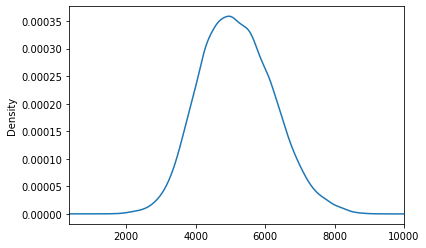

In [26]:
pd.DataFrame(data)['height'].plot(kind='kde', xlim=(360, 10000))

In [27]:
min(heights), max(heights)

(1547, 9266)

In [28]:
len([_ for _ in data if _['height'] <= 360 * 2])

0

In [29]:
for fn in [_ for _ in data if _['height'] <= 360]:
    os.remove(fn['fn'])

In [30]:
header = 160
footer = 230

In [31]:
avg - header - footer

4792.824554507338

In [32]:
4800 / 4

1200.0